# **Financial Fraud Detection**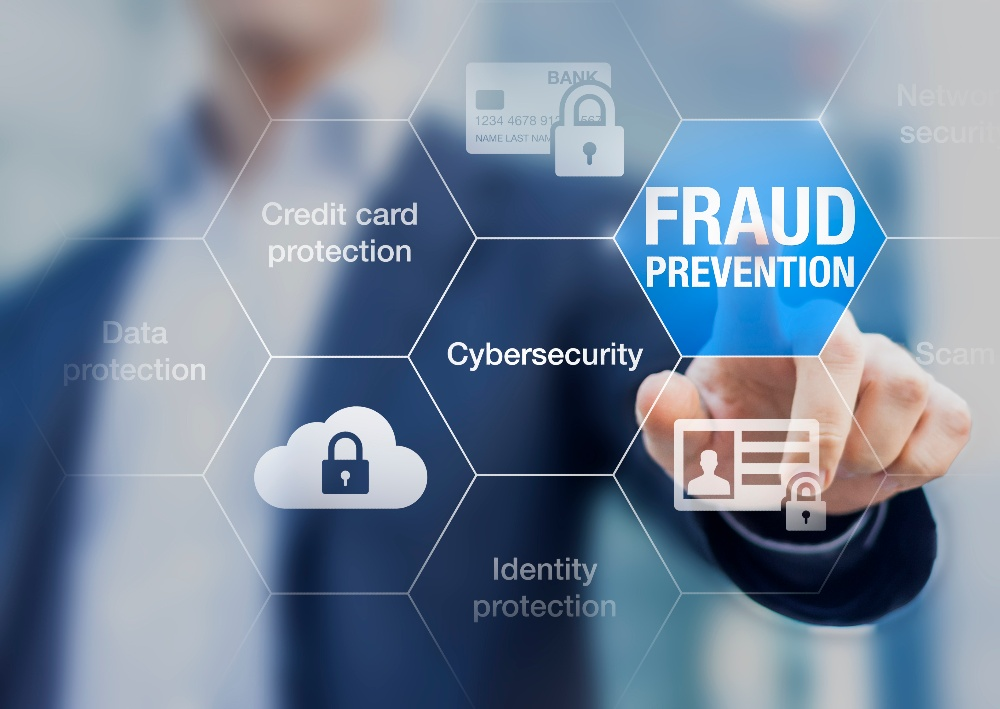

### **Introduction:**

> Financial fraud detection plays a critical role in protecting the integrity and stability of financial systems globally. As financial transactions are becoming increasingly digital and complex, the risk of fraudulent activities rises simultaneously.

> Detecting and preventing financial fraud is crucial not only for the financial institutions but also for individuals, businesses, and the overall economy. Fraudulent activities, such as identity theft, embezzlement, and cybercrimes, can lead to severe financial losses, reputational damage, and compromised personal information.

> Thus, the need for the implementation for a real-time fraud detection is imperative to maintain trust in financial systems, protect stakeholders, and uphold the law. As technology continues to evolve, the importance of remaining ahead in recognizing and addressing financial fraud cannot be emphasized enough, making it a critical aspect of modern financial management and security.

### **Financial Fraud Detection Dataset:**


> ***Source***: Kaggle



> Contains approximately 6.3 million observations distributed across 10 columns.

> With a substantial volume of data, this dataset offers a comprehensive view of financial activities, enabling analyses and insights into patterns, trends, or anomalies

# **EDA**

EDA serves as the initial step in understanding and familiarizing oneself with the characteristics of a dataset. By visually and statistically examining the data, we are able to gain insights into its structure, distribution, and potential patterns, which is crucial for making informed decisions.

In [13]:
# Only needed in Colab here we installed via terminal, not needed in VS Code where we installed via pip in the notebook.

# # Install PySpark
#!pip install pyspark

In [14]:
# NOTE: Required for running this notebook locally on Windows (VS Code).
# Not needed in Colab.

# VS Code / Windows setup fix
# Reason: Spark was hanging because JAVA_HOME and the java on PATH were mismatched.
# This forces Spark to use a single Java consistently.
import os

os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jdk-21"
os.environ["PATH"] = os.environ["JAVA_HOME"] + r"\bin;" + os.environ["PATH"]

In [15]:
import os

os.environ["HADOOP_HOME"] = r"C:\hadoop"
os.environ["hadoop.home.dir"] = r"C:\hadoop"
os.environ["PATH"] = r"C:\hadoop\bin;" + os.environ["PATH"]

from pyspark.sql import SparkSession
session = SparkSession.builder.appName("FraudDetection").getOrCreate()


In [20]:
from pyspark.sql import SparkSession

# Create Spark session
session = SparkSession.builder \
    .appName("FinalProject") \
    .master("local[2]") \
    .getOrCreate()

data = session.read.csv("transactions_train_LAST.csv", header=True, inferSchema=True)

In [17]:
from pyspark.sql.functions import col
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [21]:
print("Number of observations:",data.count())

Number of observations: 6351193


In [22]:
data.printSchema()
data.show(5)

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrig: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)

+----+--------+--------+-----------+--------------+--------------+-----------+--------------+--------------+-------+
|step|    type|  amount|   nameOrig|oldbalanceOrig|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|
+----+--------+--------+-----------+--------------+--------------+-----------+--------------+--------------+-------+
|   1| PAYMENT| 9839.64|C1231006815|      170136.0|     160296.36|M1979787155|           0.0|           0.0|      1|
|   1| PAYMENT| 1864.28|C1666544295|       21249.0|      19384.72|M2044282225|           0.0|           0.0|   

### **Checking for Missing Values in each Column:**

In [23]:
# Null counts per column (Spark doesn't have pandas-style df.isnull().sum())
# We build one aggregate expression per column and select them all at once.
from pyspark.sql.functions import col, count, when, sum

# Counts nulls by counting non-null values produced by when
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

# Cleaner / more understable style (cast boolean to int and sum)
#data.select([sum(col(c).isNull().cast('int')).alias(c) for c in data.columns]).show()

+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+
|step|type|amount|nameOrig|oldbalanceOrig|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|
+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+
|   0|   0|     0|       0|             0|             0|       0|             0|             0|      0|
+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+



### **Handling Missing Values**

In [24]:
data=data.na.drop()
data.show(5)

+----+--------+--------+-----------+--------------+--------------+-----------+--------------+--------------+-------+
|step|    type|  amount|   nameOrig|oldbalanceOrig|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|
+----+--------+--------+-----------+--------------+--------------+-----------+--------------+--------------+-------+
|   1| PAYMENT| 9839.64|C1231006815|      170136.0|     160296.36|M1979787155|           0.0|           0.0|      1|
|   1| PAYMENT| 1864.28|C1666544295|       21249.0|      19384.72|M2044282225|           0.0|           0.0|      1|
|   1|TRANSFER|   181.0|C1305486145|         181.0|           0.0| C553264065|           0.0|           0.0|      0|
|   1|CASH_OUT|   181.0| C840083671|         181.0|           0.0|  C38997010|       21182.0|           0.0|      0|
|   1| PAYMENT|11668.14|C2048537720|       41554.0|      29885.86|M1230701703|           0.0|           0.0|      1|
+----+--------+--------+-----------+--------------+-------------

### **Removing Duplicates**

In [25]:
data.dropDuplicates()
data.show(5)

+----+--------+--------+-----------+--------------+--------------+-----------+--------------+--------------+-------+
|step|    type|  amount|   nameOrig|oldbalanceOrig|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|
+----+--------+--------+-----------+--------------+--------------+-----------+--------------+--------------+-------+
|   1| PAYMENT| 9839.64|C1231006815|      170136.0|     160296.36|M1979787155|           0.0|           0.0|      1|
|   1| PAYMENT| 1864.28|C1666544295|       21249.0|      19384.72|M2044282225|           0.0|           0.0|      1|
|   1|TRANSFER|   181.0|C1305486145|         181.0|           0.0| C553264065|           0.0|           0.0|      0|
|   1|CASH_OUT|   181.0| C840083671|         181.0|           0.0|  C38997010|       21182.0|           0.0|      0|
|   1| PAYMENT|11668.14|C2048537720|       41554.0|      29885.86|M1230701703|           0.0|           0.0|      1|
+----+--------+--------+-----------+--------------+-------------

### **Display Columns**

In [26]:
data.columns

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrig',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud']

***Column Descriptions:***

*   **step:** Represents a unit of time in the real world, where 1 step is equivalent to 1 hour.

*   **type:** Type of transaction such as CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER.

*   **amount:** Represents the amount of the transaction in local currency.

*   **nameOrig:** Identifies the customer who initiated the transaction.
*   **oldbalanceOrg:** Indicates the initial balance of the customer's account before the transaction.
*   **newbalanceOrig:** Represents the customer's balance after the transaction.
*   **nameDest:** Identifies the recipient of the transaction.
*   **oldbalanceDest:** Indicates the initial balance of the recipient's account before the transaction.
*   **newbalanceDest:** Represents the recipient's balance after the transaction.
*   **isFraud:** Identifies whether a transaction is fraudulent (1) or non-fraudulent (0).


### **Display Schema**

In [27]:
print("Schema:")
data.printSchema()

Schema:
root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrig: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)



### **Overview of the Summary Statistics**

In [28]:
print("\nSummary Statistics:")
data.describe().show()


Summary Statistics:
+-------+------------------+--------+-----------------+-----------+-----------------+------------------+-----------+------------------+------------------+--------------------+
|summary|              step|    type|           amount|   nameOrig|   oldbalanceOrig|    newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|
+-------+------------------+--------+-----------------+-----------+-----------------+------------------+-----------+------------------+------------------+--------------------+
|  count|           6351193| 6351193|          6351193|    6351193|          6351193|           6351193|    6351193|           6351193|           6351193|             6351193|
|   mean|242.55529819358347|    NULL|179815.5359635669|       NULL|834795.6840371998|  856169.582831443|       NULL|1101042.5969942801|1225371.9736932502|0.040569071039094545|
| stddev|141.06763627792867|    NULL|603630.9774416926|       NULL|2889959.094210148|2926073.059621

### **Necessary Data Types Conversions**

In [29]:
updated_data = data
# Define the columns containing numeric data in string format
convert_to_float = ['amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']

# Convert the specified columns to float
for col_name in convert_to_float:
    updated_data = updated_data.withColumn(col_name, col(col_name).cast("float"))

# **Implementation of Min Max Scalar**

In [30]:
#Implementing min max scaler

columns_to_scale = ['amount', 'oldbalanceOrig', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest']

# Assemble the columns to be scaled into a vector
#newdata is just a transformer object(instructions)
newdata = VectorAssembler(inputCols=columns_to_scale, outputCol="features")
vector_df = newdata.transform(updated_data)   # creating the new collumn 'features' which has vector of features

# Initialize the MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

scaler_model = scaler.fit(vector_df)

# Scale the features
scaled_df = scaler_model.transform(vector_df)

scaled_df.select('scaled_features').show(truncate=False)

+-------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                              |
+-------------------------------------------------------------------------------------------------------------+
|[1.0643717130302798E-4,0.0028553475838901843,0.0032327564800794756,0.0,0.0]                                  |
|[2.0166256074895514E-5,3.5661635873702525E-4,3.90938894132686E-4,0.0,0.0]                                    |
|[1.957909912778899E-6,3.0376752285472994E-6,0.0,0.0,0.0]                                                     |
|[1.957909912778899E-6,3.0376752285472994E-6,0.0,5.949734200638408E-5,0.0]                                    |
|[1.2621638829483028E-4,6.973898146246104E-4,6.027192753096498E-4,0.0,0.0]                                    |
|[8.456559020856284E-5,9.039181646936881E-4,9.285520201758433E-4,0.0,0.0]                               

#### **Original values of these features have been scaled to be within the [0, 1] range. We are able to gain insights into the relative magnitudes of different features.**

# **Plotting Correlation Matrix as Heat Map**

In [31]:
# Plotting correaltion matrix as heat map
correlation_matrix = Correlation.corr(vector_df, "features").head()[0]

# Extract correlation values and print the correlation matrix
print("Correlation Matrix:")
for row in correlation_matrix.toArray():
    print("\t".join([str(elem) for elem in row]))

Correlation Matrix:
1.0	-0.0035426190870580855	-0.008152625084955992	0.2947921987233578	0.4600652995022981
-0.0035426190870580855	1.0	0.9988570006598869	0.06630077062847668	0.042019251038049044
-0.008152625084955992	0.9988570006598869	1.0	0.06785150193394517	0.04185302684269418
0.2947921987233578	0.06630077062847668	0.06785150193394517	1.0	0.976549753392222
0.4600652995022981	0.042019251038049044	0.04185302684269418	0.976549753392222	1.0


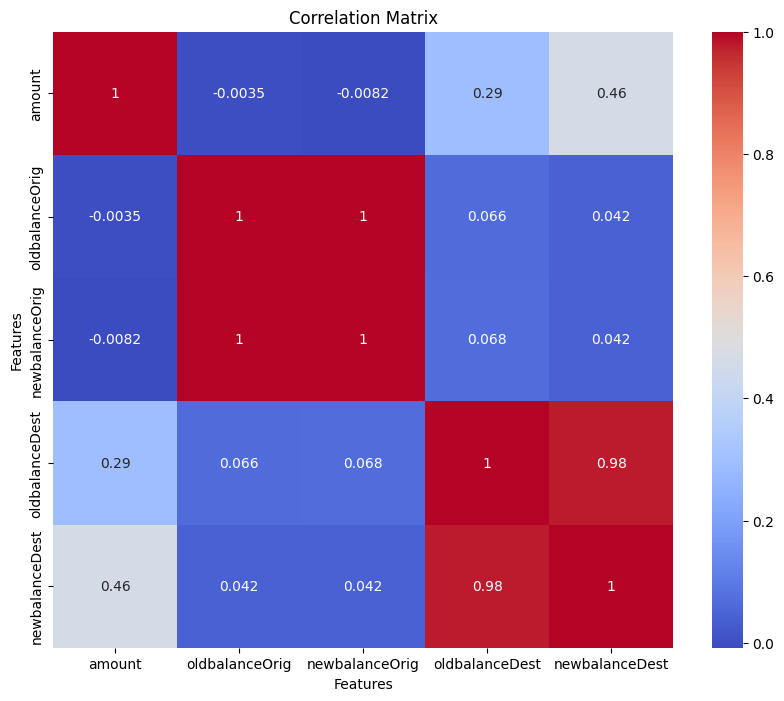

In [32]:
corr_array = correlation_matrix.toArray()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_array, annot=True, cmap='coolwarm', xticklabels=columns_to_scale, yticklabels=columns_to_scale)
plt.title("Correlation Matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

###**Observations:**

>**Old Balance Destination and New Balance Destination:**

>> The correlation coefficient is approximately 0.9765, indicating a very strong positive correlation between the 'oldbalanceDest' and 'newbalanceDest' of the transaction. This is expected, as they represent the initial and final balances of the recipient.

> **Amount and New Balance Destination:**

>> The correlation coefficient is approximately 0.4601, indicating a moderate positive correlation between the 'amount' of the transaction and the 'newbalanceDest' (new balance of the recipient) of the transaction.

> **Old Balance Origin and New Balance Destination:**

>> The correlation coefficient is approximately 0.0420, indicating a very weak positive correlation between the 'oldbalanceOrig' and 'newbalanceDest' of the transaction.


# **Visualize Distribution of 'isFraud' column**

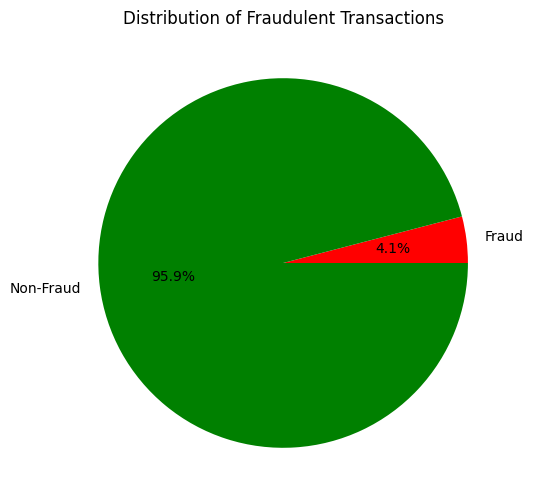

In [34]:
# Visualize the distribution of 'isFraud' column
# Map labels so 0/1 are readable in the chart
label_map = {0: 'Non-Fraud', 1: 'Fraud'}

fraud_count = data.groupBy("isFraud").count().collect()
fraud_labels = [label_map.get(int(row['isFraud']), str(row['isFraud'])) for row in fraud_count]
fraud_values = [row['count'] for row in fraud_count]

plt.figure(figsize=(6, 6))
plt.pie(fraud_values, labels=fraud_labels, autopct='%1.1f%%', colors=['red', 'green'])
plt.title("Distribution of Fraudulent Transactions")
plt.show()


**The dataset exhibits a significant class imbalance, with the majority (95.9%) of transactions labeled as non-fraudulent (class 0) and a smaller proportion (4.1%) labeled as fraudulent (class 1).**

# **Finding Categorical Distribution for Total Transactions**

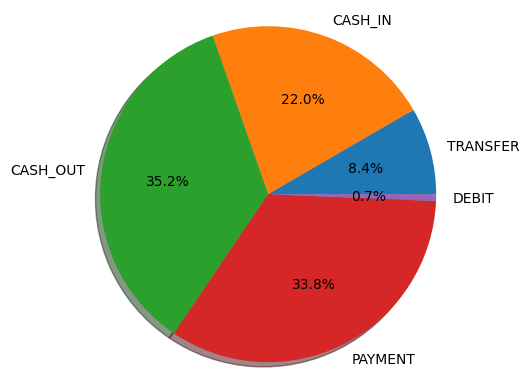

In [35]:
# Finding categorical feature distribution

labels = [row['type'] for row in data.select('type').distinct().collect()]
counts = [row['count'] for row in data.groupBy('type').count().collect()]

# Plotting the pie chart
fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=labels, autopct='%1.1f%%', shadow=True) # autopct shows the percentage on the plot
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**Majority of the transactions are of the cash_out type as it has the highest percentage with 35.2%. Second, is payment type with 33.8%. The least amount of transactions were the debit type with 0.7%.**

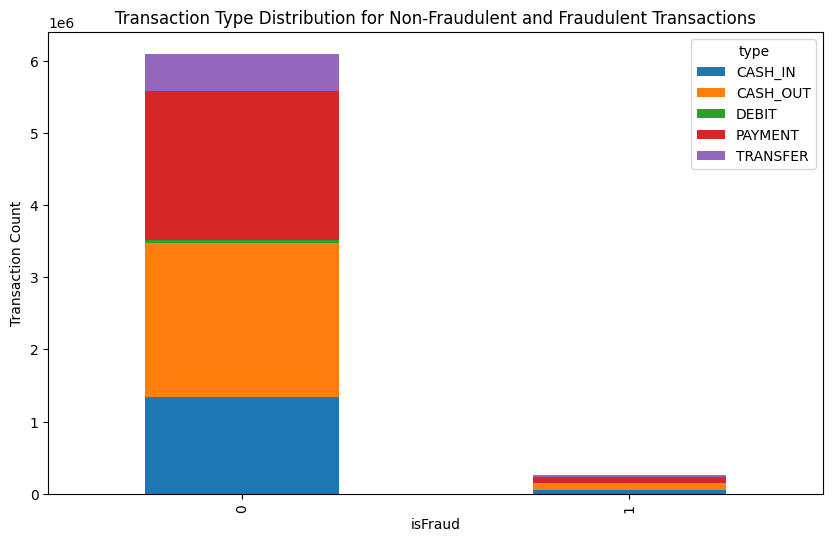

In [36]:
import pandas as pd

# Group by 'isFraud' and 'type', and count the occurrences
type_distribution = data.groupBy('isFraud', 'type').count().orderBy('isFraud', 'type').toPandas()

# Pivot the DataFrame to have 'type' values as columns
pivot_df = type_distribution.pivot(index='isFraud', columns='type', values='count').fillna(0)

# Plotting the stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Transaction Type Distribution for Non-Fraudulent and Fraudulent Transactions')
plt.xlabel('isFraud')
plt.ylabel('Transaction Count')
plt.show()

 **We can learn from this chart that most of the transactions that are classified as fraud are of the Payment and Cash Out type. Very few are transfer transactions and there are no debit transactions that were classified as fraud.**



# **K Means Clustering**

In [37]:
# Train the K-means model
kmeanmod = KMeans(featuresCol="features", k=3)
model = kmeanmod.fit(vector_df)

# the .fit() method essentially takes the vector_df, extracts the data from 
# its features column (which contains the combined vectors of your original
# numerical columns) and then performs the K-means clustering using that data.

In [38]:
# this will add a new column 'prediction'
# to the dataframe with the cluster assignment for each row

predictions = model.transform(vector_df)

print("Cluster Centers:")
centers = model.clusterCenters()
for center in centers:
    print(center)

Cluster Centers:
[151317.92512764 783291.14597511 803827.83579014 606142.60525761
 696187.53812221]
[  663089.25228968  1864810.73869778  1902885.13928089  9994865.16294701
 10703242.89204954]
[ 6797526.92376101  1032771.4857891   1060552.13695535 78382845.1933185
 86270442.83507723]


In [55]:
# K-Means on scaled features + fraud rate per cluster (exploratory)
# This avoids large balance columns dominating the clustering.

# Training KMeans using scaled features
kmean_scaled = KMeans(featuresCol="scaled_features", k=5)
scaled_model = kmean_scaled.fit(scaled_df)
scaled_predictions = scaled_model.transform(scaled_df)

# Compute fraud rate per cluster
from pyspark.sql.functions import avg
cluster_fraud = (scaled_predictions
    .groupBy('prediction')
    .agg((avg('isFraud')*100).alias('fraud_rate'), count('*').alias('count'))
    .orderBy('prediction')
)
cluster_fraud.show()


+----------+------------------+-------+
|prediction|        fraud_rate|  count|
+----------+------------------+-------+
|         0| 4.033227611979511|5709348|
|         1|4.5067889992853685|  43379|
|         2|4.4793784288061484|  71818|
|         3|4.0772769975670275| 207565|
|         4|4.3111040074212665| 319083|
+----------+------------------+-------+



### ***Observations:***

> Cluster 1:

>> Represents transactions with relatively moderate values for 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', and 'newbalanceDest'.

> Cluster 2:

>> Represent transactions with higher values, particularly in 'oldbalanceOrig' and 'newbalanceOrig'. This includes transactions involving accounts with higher initial and final balances.

> Cluster 3:

>> Represent transactions with even higher values, especially in 'amount', 'oldbalanceOrig', and 'newbalanceDest'. This includes transactions with large amounts and involving accounts with high balances.

The big cluster has the same fraud rate as overall baseline and the small ones don’t differ much, K‑Means isn’t giving signal and is safe to ignore.

# **Spark SQL**

In [41]:
data.createOrReplaceTempView("transactions")

# Show the first 5 rows of transactions
result1 = session.sql("SELECT * FROM transactions LIMIT 5")
result1.show()

+----+--------+--------+-----------+--------------+--------------+-----------+--------------+--------------+-------+
|step|    type|  amount|   nameOrig|oldbalanceOrig|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|
+----+--------+--------+-----------+--------------+--------------+-----------+--------------+--------------+-------+
|   1| PAYMENT| 9839.64|C1231006815|      170136.0|     160296.36|M1979787155|           0.0|           0.0|      1|
|   1| PAYMENT| 1864.28|C1666544295|       21249.0|      19384.72|M2044282225|           0.0|           0.0|      1|
|   1|TRANSFER|   181.0|C1305486145|         181.0|           0.0| C553264065|           0.0|           0.0|      0|
|   1|CASH_OUT|   181.0| C840083671|         181.0|           0.0|  C38997010|       21182.0|           0.0|      0|
|   1| PAYMENT|11668.14|C2048537720|       41554.0|      29885.86|M1230701703|           0.0|           0.0|      1|
+----+--------+--------+-----------+--------------+-------------

In [42]:
total_transaction_count = session.sql("SELECT COUNT(*) AS total_transactions FROM transactions")

# Show the result
total_transaction_count.show()

+------------------+
|total_transactions|
+------------------+
|           6351193|
+------------------+



**6,351,193 transactions (observations)**

In [43]:
# Show the count of Fraud and Non-Fraud transactions
result2 = session.sql("SELECT isFraud, COUNT(*) as count FROM transactions GROUP BY isFraud")
result2.show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1| 257662|
|      0|6093531|
+-------+-------+



**Informs us that out of approximately 6.3 million rows, only 257,662 (4%) transactions were classified as fraud.**

In [44]:
# Show the average amount for Fraud and Non-Fraud transactions
result3 = session.sql("SELECT isFraud, AVG(amount) as avg_amount FROM transactions GROUP BY isFraud")
result3.show()

+-------+------------------+
|isFraud|        avg_amount|
+-------+------------------+
|      1|203237.27377533223|
|      0|178825.15915116383|
+-------+------------------+



**The average amount for fraudulent transactions is approximately 203,237. The average amount for non-fraudulent transactions is approximately 178,825.**

**On average, fraudulent transactions tend to have a higher amount compared to non-fraudulent transactions. The difference in average amounts between the two classes suggests that amount could be a significant feature in distinguishing between fraud and non-fraud transactions. This information can be valuable for feature selection in fraud detection models, as it highlights a potential discriminative feature.**

In [52]:
# Transaction Frequency Analysis
result4 = "SELECT type, COUNT(*) AS transaction_count FROM transactions GROUP BY type ORDER BY type"

transaction_frequency = session.sql(result4)
transaction_frequency.show()

+--------+-----------------+
|    type|transaction_count|
+--------+-----------------+
| CASH_IN|          1396865|
|CASH_OUT|          2233369|
|   DEBIT|            41310|
| PAYMENT|          2147832|
|TRANSFER|           531817|
+--------+-----------------+



**There is a significant imbalance in the distribution of transaction types, with 'CASH_OUT' and 'PAYMENT' dominating the dataset. The transaction type information could be an important feature for fraud detection models.**

In [53]:
# Account Balance Changes Analysis
result5 = """
    SELECT
        nameOrig,
        oldbalanceOrig,
        newbalanceOrig,
        (newbalanceOrig - oldbalanceOrig) AS balance_change
    FROM
        transactions
    ORDER BY
        balance_change DESC
"""

account_balance_changes = session.sql(result5)
account_balance_changes.show()

+-----------+--------------+--------------+------------------+
|   nameOrig|oldbalanceOrig|newbalanceOrig|    balance_change|
+-----------+--------------+--------------+------------------+
|C1603141931| 1.682045738E7| 1.873572528E7|1915267.9000000022|
|C1072983741| 1.481889469E7| 1.664017422E7|1821279.5300000012|
|C1719006755| 1.565768723E7| 1.744030872E7|1782621.4899999984|
| C866302906| 1.503158603E7| 1.681349128E7|1781905.2500000019|
|C1139859398| 1.861712814E7| 2.029226574E7|1675137.5999999978|
|C1931735461| 1.425974733E7| 1.586903545E7|1609288.1199999992|
|C1065575100| 1.963899484E7| 2.124110804E7|1602113.1999999993|
|C1130769687| 2.242821014E7| 2.401649141E7|1588281.2699999996|
|C1747502623| 1.740028891E7|  1.89742129E7|1573923.9899999984|
| C263860433| 2.643417608E7| 2.796391505E7|1529738.9700000025|
|C1095502692| 2.265489613E7| 2.415280855E7|1497912.4200000018|
|C1278066124| 1.666954581E7| 1.813385323E7|        1464307.42|
|C1699685633| 2.130033148E7| 2.275749011E7| 1457158.629

Appears to have large balance changes as there are transactions in the results that display substantial changes in account balances, with some transactions having balance changes in the millions. Transactions with exceptionally large balance changes may warrant further investigation, as they could be indicative of unusual or potentially fraudulent activities. Unusually large or rapid changes in account balances may be indicative of fraudulent behavior.

**Note before Model Evaluation:** Fraud data is highly imbalanced (mostly non-fraud). Because of this, accuracy can look high even for weak models that miss fraud. To compare models fairly, we use **AUC (Area Under the ROC Curve)**, which measures ranking quality across thresholds and uses the model's score (`rawPrediction`). We report AUC (not accuracy) for all models below.

# **Logistic Regression Model**

In [54]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

# Stratified Splitting for train-test data creation
frauds = updated_data.filter(col("isFraud") == 1)
non_frauds = updated_data.filter(col("isFraud") == 0)

train_frauds, test_frauds = frauds.randomSplit([0.7, 0.3], seed=42)
train_non_frauds, test_non_frauds = non_frauds.randomSplit([0.7, 0.3], seed=42)

train_final = train_frauds.union(train_non_frauds)
test_final = test_frauds.union(test_non_frauds)

# Define StringIndexer for categorical variable 'type'
str_obj = StringIndexer(inputCols=["type"], outputCols=["newtype"], stringOrderType="alphabetAsc")

# Define OneHotEncoder for the indexed categorical variable
onehot_obj = OneHotEncoder(inputCols=["newtype"], outputCols=["newtype2"])

# Define VectorAssembler for combining features
vector_object = VectorAssembler(inputCols=["newtype2", "amount", "oldbalanceOrig",
                                            "newbalanceOrig", "oldbalanceDest",
                                            "newbalanceDest"], outputCol="allfeatures")


In [58]:
# Define Logistic Regression model
lr = LogisticRegression(featuresCol='allfeatures', labelCol="isFraud")

# Define Pipeline with all the stages
log_reg_pipeline = Pipeline(stages=[str_obj, onehot_obj, vector_object, lr])

# Train the model using the defined pipeline
if train_final.select("isFraud").distinct().count() < 2:
    print("Skipping Logistic Regression: only one class present.")
else:
    lrmodel = log_reg_pipeline.fit(train_final)

# Make predictions on the test dataset
    lrresults = lrmodel.transform(test_final)

# Display the results
    lrresults.show(5, truncate=False)

    # Evaluate the model using BinaryClassificationEvaluator
    lreval = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="isFraud")
    roc_auc = lreval.evaluate(lrresults)
    print("Area under ROC curve: ", roc_auc)

+----+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-------+-------+-------------+-----------------------------------------------------------------------------------------+----------------------------------------+-----------------------------------------+----------+
|step|type   |amount |nameOrig   |oldbalanceOrig|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|newtype|newtype2     |allfeatures                                                                              |rawPrediction                           |probability                              |prediction|
+----+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-------+-------+-------------+-----------------------------------------------------------------------------------------+----------------------------------------+-----------------------------------------+----------+
|1   |CASH_IN|911.76 |C566760932 |133

In [59]:
data.printSchema()


root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrig: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)



# **Random Forest Classifier**

In [60]:
from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(featuresCol='allfeatures', labelCol="isFraud")
rf_pipeline = Pipeline(stages=[str_obj, onehot_obj, vector_object, rfc])

if train_final.select("isFraud").distinct().count() < 2:
    print("Skipping Random Forest: only one class present.")
else:
    rf_model = rf_pipeline.fit(train_final)
    rf_results = rf_model.transform(test_final)
    rf_results.show(2, truncate=False)
    rf_evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")
    rf_accuracy = rf_evaluator.evaluate(rf_results)
    print("Random Forest Model Accuracy:", rf_accuracy)


+----+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-------+-------+-------------+-----------------------------------------------------------------------------------------+---------------------------------------+-----------------------------------------+----------+
|step|type   |amount |nameOrig   |oldbalanceOrig|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|newtype|newtype2     |allfeatures                                                                              |rawPrediction                          |probability                              |prediction|
+----+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-------+-------+-------------+-----------------------------------------------------------------------------------------+---------------------------------------+-----------------------------------------+----------+
|1   |CASH_IN|911.76 |C566760932 |133563

In [70]:
#BinaryClassificationEvaluator reports AUC (area under ROC), not accuracy. 
# So this is AUC

print("Random Forest Model Accuracy:", rf_accuracy)   

Random Forest Model Accuracy: 0.5051054606478944


# **Support Vector Machine (SVM)**

In [67]:
# code for implementing SUPPORT VECTOR MACHINE

from pyspark.ml.classification import LinearSVC
svm = LinearSVC(featuresCol='allfeatures', labelCol="isFraud")

# Creating a pipeline
from pyspark.ml import Pipeline
svmpipeline = Pipeline(stages=[str_obj, onehot_obj, vector_object, svm])

# Training the model
#svmmodel = svmpipeline.fit(train_final)

#for now
if train_final.select("isFraud").distinct().count() < 2:
    print("Skipping SVM: only one class present.")
else:
    svmmodel = svmpipeline.fit(train_final)
    svmresults = svmmodel.transform(test_final) # Predicting the results on the test dataset
    svmresults.show(2, truncate=False)  # Displaying the results


# Predicting the results on the test dataset
#svmresults = svmmodel.transform(test_final)

# Displaying the results
#svmresults.show(2, truncate=False)


+----+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-------+-------+-------------+-----------------------------------------------------------------------------------------+----------------------------------------+----------+
|step|type   |amount |nameOrig   |oldbalanceOrig|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|newtype|newtype2     |allfeatures                                                                              |rawPrediction                           |prediction|
+----+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-------+-------+-------------+-----------------------------------------------------------------------------------------+----------------------------------------+----------+
|1   |CASH_IN|911.76 |C566760932 |1335635.5     |1336547.2     |C1364913072|48321.6       |47409.85      |1.0    |0.0    |(4,[0],[1.0])|[1.0,0.0,0.0,0.0,911.760009

In [68]:
# Evaluate the model. Again this is AUC than accuracy.
if train_final.select("isFraud").distinct().count() < 2:
    print("Skipping SVM evaluation: only one class present.")
else:
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="isFraud")
    accuracy = evaluator.evaluate(svmresults)
    print("Accuracy:", accuracy)


Accuracy: 0.536932276803019


# **Decision Tree Model**

In [71]:
from pyspark.ml.classification import DecisionTreeClassifier
tree=DecisionTreeClassifier(featuresCol='allfeatures', labelCol="isFraud")
treepipeline=Pipeline(stages=[str_obj,onehot_obj,vector_object,tree])

if train_final.select("isFraud").distinct().count() < 2:
    print("Skipping Decision Tree: only one class present.")
else:
    treemodel=treepipeline.fit(train_final)
    treeresults=treemodel.transform(test_final)
    treeresults.show(2, truncate=False)
    treeeval=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="isFraud")

+----+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-------+-------+-------------+-----------------------------------------------------------------------------------------+------------------+---------------------------------------+----------+
|step|type   |amount |nameOrig   |oldbalanceOrig|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|newtype|newtype2     |allfeatures                                                                              |rawPrediction     |probability                            |prediction|
+----+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-------+-------+-------------+-----------------------------------------------------------------------------------------+------------------+---------------------------------------+----------+
|1   |CASH_IN|911.76 |C566760932 |1335635.5     |1336547.2     |C1364913072|48321.6       |47409.85      |1.0

In [72]:
accuracy = treeeval.evaluate(treeresults)
print("Decision Tree AUC:", accuracy)

Decision Tree AUC: 0.47034309238106903


# **Gradient Booster Model**

In [73]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol='allfeatures', labelCol='isFraud')

# Creating a pipeline
gbmpipeline = Pipeline(stages=[str_obj, onehot_obj, vector_object, gbt])

# Training the model
if train_final.select("isFraud").distinct().count() < 2:
    print("Skipping Gradient Booster: only one class present.")
else:
    gbmmodel = gbmpipeline.fit(train_final)

# Predicting the results on the test dataset
    gbmresults = gbmmodel.transform(test_final)
    gbmresults.show(2, truncate=False)

+----+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-------+-------+-------------+-----------------------------------------------------------------------------------------+----------------------------------------+----------------------------------------+----------+
|step|type   |amount |nameOrig   |oldbalanceOrig|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|newtype|newtype2     |allfeatures                                                                              |rawPrediction                           |probability                             |prediction|
+----+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-------+-------+-------------+-----------------------------------------------------------------------------------------+----------------------------------------+----------------------------------------+----------+
|1   |CASH_IN|911.76 |C566760932 |133563

In [75]:
# Evaluate accuracy
if train_final.select("isFraud").distinct().count() < 2:
    print("Skipping Gradient Booster evaluation: only one class present.")
else:
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="isFraud")
    accuracy = evaluator.evaluate(gbmresults)
    print("Accuracy:", accuracy)


Accuracy: 0.5914572930124775


# **Spark Streaming**

In [8]:
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import os
import shutil

directories = ["Input", "Output"]


for dir_name in directories:
    dir_path = os.path.join(dir_name)

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Directory '{dir_path}' created.")
    else:
        print(f"Directory '{dir_path}' already exists.")

schema = StructType([
    StructField("step", IntegerType(), nullable=True),
    StructField("type", StringType(), nullable=True),
    StructField("amount", DoubleType(), nullable=True),
    StructField("nameOrig", StringType(), nullable=True),
    StructField("oldbalanceOrig", DoubleType(), nullable=True),
    StructField("newbalanceOrig", DoubleType(), nullable=True),
    StructField("nameDest", StringType(), nullable=True),
    StructField("oldbalanceDest", DoubleType(), nullable=True),
    StructField("newbalanceDest", DoubleType(), nullable=True),
    StructField("isFraud", IntegerType(), nullable=True)
])

finance_data = session.readStream.schema(schema).csv("Input/")

fraud_query = finance_data.writeStream.queryName("financefraudtable").format("memory").outputMode("append").start()

Directory 'Input' already exists.
Directory 'Output' already exists.


Py4JJavaError: An error occurred while calling o52.csv.
: java.lang.UnsatisfiedLinkError: 'boolean org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(java.lang.String, int)'
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:817)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1415)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1620)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:802)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2078)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2122)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:1020)
	at org.apache.spark.util.HadoopFSUtils$.listLeafFiles(HadoopFSUtils.scala:218)
	at org.apache.spark.util.HadoopFSUtils$.$anonfun$parallelListLeafFilesInternal$1(HadoopFSUtils.scala:132)
	at scala.collection.immutable.List.map(List.scala:236)
	at scala.collection.immutable.List.map(List.scala:79)
	at org.apache.spark.util.HadoopFSUtils$.parallelListLeafFilesInternal(HadoopFSUtils.scala:122)
	at org.apache.spark.util.HadoopFSUtils$.parallelListLeafFiles(HadoopFSUtils.scala:72)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex$.bulkListLeafFiles(InMemoryFileIndex.scala:179)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.listLeafFiles(InMemoryFileIndex.scala:135)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.refresh0(InMemoryFileIndex.scala:98)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.<init>(InMemoryFileIndex.scala:70)
	at org.apache.spark.sql.execution.datasources.DataSource.createInMemoryFileIndex(DataSource.scala:568)
	at org.apache.spark.sql.execution.datasources.DataSource.$anonfun$sourceSchema$2(DataSource.scala:283)
	at org.apache.spark.sql.execution.datasources.DataSource.tempFileIndex$lzycompute$1(DataSource.scala:176)
	at org.apache.spark.sql.execution.datasources.DataSource.tempFileIndex$1(DataSource.scala:176)
	at org.apache.spark.sql.execution.datasources.DataSource.getOrInferFileFormatSchema(DataSource.scala:181)
	at org.apache.spark.sql.execution.datasources.DataSource.sourceSchema(DataSource.scala:277)
	at org.apache.spark.sql.execution.datasources.DataSource.sourceInfo$lzycompute(DataSource.scala:132)
	at org.apache.spark.sql.execution.datasources.DataSource.sourceInfo(DataSource.scala:132)
	at org.apache.spark.sql.execution.streaming.runtime.StreamingRelation$.apply(StreamingRelation.scala:38)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:119)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:45)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:139)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:107)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:139)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:416)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:135)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:131)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp(AnalysisHelper.scala:112)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp$(AnalysisHelper.scala:111)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUp(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:45)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:43)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:248)
	at scala.collection.LinearSeqOps.foldLeft(LinearSeq.scala:183)
	at scala.collection.LinearSeqOps.foldLeft$(LinearSeq.scala:179)
	at scala.collection.immutable.List.foldLeft(List.scala:79)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:245)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:237)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:237)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:343)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:339)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:224)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:339)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:289)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:207)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:207)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.resolveInFixedPoint(HybridAnalyzer.scala:236)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.$anonfun$apply$1(HybridAnalyzer.scala:91)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.withTrackedAnalyzerBridgeState(HybridAnalyzer.scala:122)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.apply(HybridAnalyzer.scala:84)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:322)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:423)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:322)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$2(QueryExecution.scala:139)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:148)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:330)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:717)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:330)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:329)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$1(QueryExecution.scala:139)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1392)
	at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:150)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:90)
	at org.apache.spark.sql.classic.Dataset$.$anonfun$ofRows$1(Dataset.scala:114)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.classic.Dataset$.ofRows(Dataset.scala:112)
	at org.apache.spark.sql.classic.DataStreamReader.loadInternal(DataStreamReader.scala:81)
	at org.apache.spark.sql.classic.DataStreamReader.load(DataStreamReader.scala:90)
	at org.apache.spark.sql.classic.DataStreamReader.load(DataStreamReader.scala:41)
	at org.apache.spark.sql.streaming.DataStreamReader.csv(DataStreamReader.scala:164)
	at org.apache.spark.sql.classic.DataStreamReader.csv(DataStreamReader.scala:138)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)


In [82]:
# Allow the stream to process available files in Input/
fraud_query.processAllAvailable()


NameError: name 'fraud_query' is not defined

NameError: name 'spark' is not defined

Create a finaldirectory folder

After running block above, add train2, train3, train4 csv files into input


In [83]:
session.sql("SELECT * FROM financefraudtable").show(5)

Py4JJavaError: An error occurred while calling o28.sql.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://cwiki.apache.org/confluence/display/HADOOP2/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:789)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:298)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:314)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:1179)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:861)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:901)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:873)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:1047)
	at org.apache.spark.sql.catalyst.catalog.InMemoryCatalog.liftedTree1$1(InMemoryCatalog.scala:122)
	at org.apache.spark.sql.catalyst.catalog.InMemoryCatalog.createDatabase(InMemoryCatalog.scala:119)
	at org.apache.spark.sql.internal.SharedState.externalCatalog$lzycompute(SharedState.scala:168)
	at org.apache.spark.sql.internal.SharedState.externalCatalog(SharedState.scala:149)
	at org.apache.spark.sql.internal.BaseSessionStateBuilder.$anonfun$catalog$1(BaseSessionStateBuilder.scala:164)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.externalCatalog$lzycompute(SessionCatalog.scala:129)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.externalCatalog(SessionCatalog.scala:129)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.databaseExists(SessionCatalog.scala:336)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.requireDbExists(SessionCatalog.scala:264)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.getTableRawMetadata(SessionCatalog.scala:585)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.getTableMetadata(SessionCatalog.scala:571)
	at org.apache.spark.sql.execution.datasources.v2.V2SessionCatalog.loadTable(V2SessionCatalog.scala:91)
	at org.apache.spark.sql.connector.catalog.CatalogV2Util$.getTable(CatalogV2Util.scala:483)
	at org.apache.spark.sql.connector.catalog.CatalogV2Util$.loadTable(CatalogV2Util.scala:458)
	at org.apache.spark.sql.catalyst.analysis.RelationResolution.$anonfun$resolveRelation$4(RelationResolution.scala:131)
	at scala.Option.orElse(Option.scala:477)
	at org.apache.spark.sql.catalyst.analysis.RelationResolution.$anonfun$resolveRelation$2(RelationResolution.scala:124)
	at scala.Option.orElse(Option.scala:477)
	at org.apache.spark.sql.catalyst.analysis.RelationResolution.resolveRelation(RelationResolution.scala:117)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.resolveRelation(Analyzer.scala:1323)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$$anonfun$apply$12.applyOrElse(Analyzer.scala:1244)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$$anonfun$apply$12.applyOrElse(Analyzer.scala:1205)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:139)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:107)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:139)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:416)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:135)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:131)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$2(AnalysisHelper.scala:136)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1264)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1263)
	at org.apache.spark.sql.catalyst.plans.logical.Project.mapChildren(basicLogicalOperators.scala:73)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:136)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:416)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:135)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:131)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.apply(Analyzer.scala:1205)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.apply(Analyzer.scala:1167)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:248)
	at scala.collection.LinearSeqOps.foldLeft(LinearSeq.scala:183)
	at scala.collection.LinearSeqOps.foldLeft$(LinearSeq.scala:179)
	at scala.collection.immutable.List.foldLeft(List.scala:79)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:245)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:237)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:237)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:343)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:339)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:224)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:339)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:289)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:207)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:207)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.resolveInFixedPoint(HybridAnalyzer.scala:236)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.$anonfun$apply$1(HybridAnalyzer.scala:91)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.withTrackedAnalyzerBridgeState(HybridAnalyzer.scala:122)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.apply(HybridAnalyzer.scala:84)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:322)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:423)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:322)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$2(QueryExecution.scala:139)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:148)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:330)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:717)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:330)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:329)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$1(QueryExecution.scala:139)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1392)
	at org.apache.spark.util.Utils$.getTryWithCallerStacktrace(Utils.scala:1453)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:150)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:90)
	at org.apache.spark.sql.classic.Dataset$.$anonfun$ofRows$5(Dataset.scala:138)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.classic.Dataset$.ofRows(Dataset.scala:135)
	at org.apache.spark.sql.classic.SparkSession.$anonfun$sql$1(SparkSession.scala:532)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.classic.SparkSession.sql(SparkSession.scala:502)
	at org.apache.spark.sql.classic.SparkSession.sql(SparkSession.scala:537)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)
	Suppressed: org.apache.spark.util.Utils$OriginalTryStackTraceException: Full stacktrace of original doTryWithCallerStacktrace caller
		at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:789)
		at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:298)
		at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:314)
		at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:1179)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:861)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:901)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:873)
		at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:1047)
		at org.apache.spark.sql.catalyst.catalog.InMemoryCatalog.liftedTree1$1(InMemoryCatalog.scala:122)
		at org.apache.spark.sql.catalyst.catalog.InMemoryCatalog.createDatabase(InMemoryCatalog.scala:119)
		at org.apache.spark.sql.internal.SharedState.externalCatalog$lzycompute(SharedState.scala:168)
		at org.apache.spark.sql.internal.SharedState.externalCatalog(SharedState.scala:149)
		at org.apache.spark.sql.internal.BaseSessionStateBuilder.$anonfun$catalog$1(BaseSessionStateBuilder.scala:164)
		at org.apache.spark.sql.catalyst.catalog.SessionCatalog.externalCatalog$lzycompute(SessionCatalog.scala:129)
		at org.apache.spark.sql.catalyst.catalog.SessionCatalog.externalCatalog(SessionCatalog.scala:129)
		at org.apache.spark.sql.catalyst.catalog.SessionCatalog.databaseExists(SessionCatalog.scala:336)
		at org.apache.spark.sql.catalyst.catalog.SessionCatalog.requireDbExists(SessionCatalog.scala:264)
		at org.apache.spark.sql.catalyst.catalog.SessionCatalog.getTableRawMetadata(SessionCatalog.scala:585)
		at org.apache.spark.sql.catalyst.catalog.SessionCatalog.getTableMetadata(SessionCatalog.scala:571)
		at org.apache.spark.sql.execution.datasources.v2.V2SessionCatalog.loadTable(V2SessionCatalog.scala:91)
		at org.apache.spark.sql.connector.catalog.CatalogV2Util$.getTable(CatalogV2Util.scala:483)
		at org.apache.spark.sql.connector.catalog.CatalogV2Util$.loadTable(CatalogV2Util.scala:458)
		at org.apache.spark.sql.catalyst.analysis.RelationResolution.$anonfun$resolveRelation$4(RelationResolution.scala:131)
		at scala.Option.orElse(Option.scala:477)
		at org.apache.spark.sql.catalyst.analysis.RelationResolution.$anonfun$resolveRelation$2(RelationResolution.scala:124)
		at scala.Option.orElse(Option.scala:477)
		at org.apache.spark.sql.catalyst.analysis.RelationResolution.resolveRelation(RelationResolution.scala:117)
		at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.resolveRelation(Analyzer.scala:1323)
		at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$$anonfun$apply$12.applyOrElse(Analyzer.scala:1244)
		at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$$anonfun$apply$12.applyOrElse(Analyzer.scala:1205)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:139)
		at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:107)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:139)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:416)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:135)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:131)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$2(AnalysisHelper.scala:136)
		at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1264)
		at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1263)
		at org.apache.spark.sql.catalyst.plans.logical.Project.mapChildren(basicLogicalOperators.scala:73)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:136)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:416)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:135)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:131)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.apply(Analyzer.scala:1205)
		at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.apply(Analyzer.scala:1167)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:248)
		at scala.collection.LinearSeqOps.foldLeft(LinearSeq.scala:183)
		at scala.collection.LinearSeqOps.foldLeft$(LinearSeq.scala:179)
		at scala.collection.immutable.List.foldLeft(List.scala:79)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:245)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:237)
		at scala.collection.immutable.List.foreach(List.scala:323)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:237)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:343)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:339)
		at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:224)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:339)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:289)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:207)
		at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:207)
		at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.resolveInFixedPoint(HybridAnalyzer.scala:236)
		at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.$anonfun$apply$1(HybridAnalyzer.scala:91)
		at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.withTrackedAnalyzerBridgeState(HybridAnalyzer.scala:122)
		at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.apply(HybridAnalyzer.scala:84)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:322)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:423)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:322)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$2(QueryExecution.scala:139)
		at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:148)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:330)
		at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:717)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:330)
		at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
		at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:329)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$1(QueryExecution.scala:139)
		at scala.util.Try$.apply(Try.scala:217)
		at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1392)
		at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
		at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
		... 22 more
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://cwiki.apache.org/confluence/display/HADOOP2/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:601)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:622)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:645)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:742)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:80)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1954)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1912)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1885)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$install$1(ShutdownHookManager.scala:194)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
	at scala.Option.fold(Option.scala:263)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:195)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:55)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:53)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:159)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala:63)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:249)
	at org.apache.spark.util.SparkFileUtils.createTempDir(SparkFileUtils.scala:125)
	at org.apache.spark.util.SparkFileUtils.createTempDir$(SparkFileUtils.scala:124)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:97)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:378)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:962)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:203)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:226)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:95)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1168)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1177)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:521)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:492)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:569)
	... 27 more


In [ ]:
# Stop the stream if it was started
if 'fraud_query' in locals():
    fraud_query.stop()


In [ ]:
final_directory = "finaldirectory"
final_file_name = "fraud_data.csv"

part_file = next(f for f in os.listdir(output_path) if f.startswith("part-00000"))

source_file_path = os.path.join(output_path, part_file)
final_file_path = os.path.join(final_directory, final_file_name)

shutil.move(source_file_path, final_file_path)

shutil.rmtree(output_path)

In [ ]:
financedata=session.read.csv("finaldirectory/fraud_data.csv", header=True, inferSchema=True)

str_obj1=StringIndexer(inputCols=["type"],outputCols=["newtype"], stringOrderType= "alphabetAsc")
onehot_obj1=OneHotEncoder(inputCols=["newtype"],outputCols=["newtype2"])
vector_object1 = VectorAssembler(inputCols=["newtype2", "amount", "oldbalanceOrig", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"], outputCol="allfeatures")

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
tree=DecisionTreeClassifier(featuresCol='allfeatures', labelCol="isFraud")
treepipeline=Pipeline(stages=[str_obj1,onehot_obj1,vector_object1,tree])
training, test= financedata.randomSplit([0.8,0.2], seed=123)
if train_final.select("isFraud").distinct().count() < 2:
    print("Skipping Decision Tree: only one class present.")
else:
    treemodel=treepipeline.fit(training)
    treeresults=treemodel.transform(test)
    treeresults.show(2, truncate=False)
    treeeval=BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="isFraud")
    treeeval.evaluate(treeresults)